# Solve the latent variable Gaussian Graphical model using cvxpy

In [1]:
import numpy as np
import networkx as nx
from scipy.sparse.linalg import eigsh
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.art3d as art3d
import os
from os import getcwd
from os.path import dirname
from time import gmtime, strftime
import scipy as sp
import cvxpy as cvx
from sklearn.linear_model import lars_path
%matplotlib inline 
import sys

cwd = getcwd()
dir_root = dirname(cwd)
filepath = os.path.join(dir_root, 'src')
sys.path.append(filepath) #('/home/tianpei/Dropbox/Codes/Python/LatNet/src/')
print(filepath)
%load_ext Cython

/home/tianpei/Dropbox/Codes/Python/LatNet/src


In [2]:
from latent_signal_network import latent_signal_network as lsn 

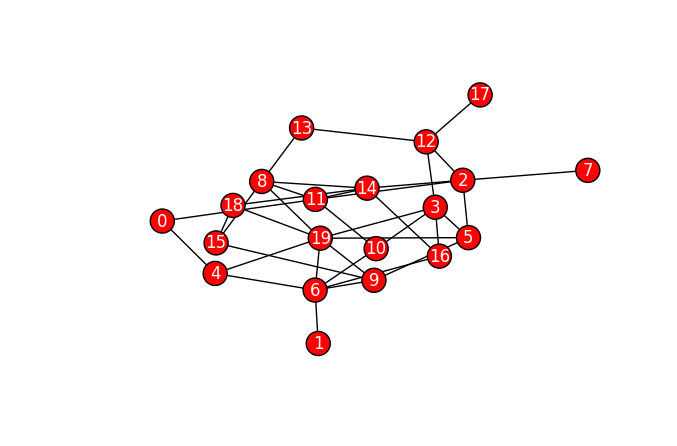

In [3]:
savefigure = False
seed = 1000
choice = 'binomial'
d = 12
if choice == 'newman':
    size = 20
    prob = 0
    option= {'seed': seed, 'node_dim': d, 'model': choice}
    option['k-NN'] = 2
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option, save_fig=savefigure)
elif choice == 'partition':
    size = [20, 20]
    prob = [0.8, 0.1]
    option= {'seed': seed, 'node_dim': d, 'model': choice}
    option['cutoff_freq'] = 12
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option, save_fig=savefigure)
elif choice == 'grid':
    size = [5, 5]
    prob = 0.6
    option= {'seed': seed, 'node_dim': d, 'model': choice}
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option)
elif choice == 'binomial':
    size = 20
    prob = 0.195

    option= {'seed': seed, 'node_dim': d, 'model': choice}
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option)
    
elif choice == 'tree':
    size = 20
    gamma = 3
    prob = 0
    option= {'seed': seed, 'node_dim': d, 'gamma': gamma ,'model': choice}
    option['cutoff_freq'] = 10
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option, save_fig=savefigure)
    
elif choice == 'balanced_tree':
    size = 20
    prob = 0
    option= {'seed': seed, 'node_dim': d, 'model': choice}
    option['r'] = 2
    option['h'] = 3
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option, save_fig=savefigure)  
    
elif choice == 'bipartite_binomial':
    size = [20, 10]
    prob =  0.4
    option= {'seed': seed, 'node_dim': d, 'model': choice}
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option, save_fig=savefigure)  
    
elif choice == 'bipartite_uniform':
    size = [20, 20]
    prob = 0.17
    num_edges = prob*size[0]*size[1]
    option= {'seed': seed, 'node_dim': d, 'model': choice}
    option['num_edges'] = num_edges
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option, save_fig=savefigure)     

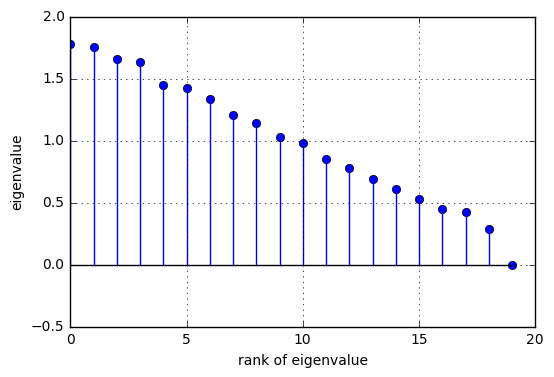

In [4]:
#Plot the eigenvalue of Laplacian matrix
Laplacian = nx.normalized_laplacian_matrix(G0).todense()
#Sigma, U = np.linalg.eigh(abs(adjMat))
Sigma, U = np.linalg.eigh(Laplacian)

index_sig = np.argsort(Sigma)
Sigma = Sigma[index_sig[::-1]]
U = U[:,index_sig[::-1]]

fig3 =plt.figure(3)
ax = plt.gca()
(markerline, stemlines, baseline) = plt.stem(np.arange(len(Sigma)), Sigma, 'b', basefmt='k-')
#plt.plot(np.arange(len(Sigma)), np.ones((len(Sigma, ))), 'r')
plt.xlabel('rank of eigenvalue')
plt.ylabel('eigenvalue')
ax.grid(True)
plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_eigenvalue_laplacian.eps"
#filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_eigenvalue_adjMat.eps"
if savefigure : fig3.savefig(filename)

In [ ]:
if 'bipartite' in choice:
    node_sets = bipartite.sets(G0)
else:
    n2 = 12
    G1=sorted(nx.connected_component_subgraphs(G0.subgraph(np.arange(n2))), key = len, reverse=True)[0]
    node_sets = []
    node_sets.append(set(G1.nodes()))
    node_sets.append(set(G0.nodes()).difference(set(G1.nodes())))
node_lists = [list(node_sets[0]), list(node_sets[1])]
node_lists

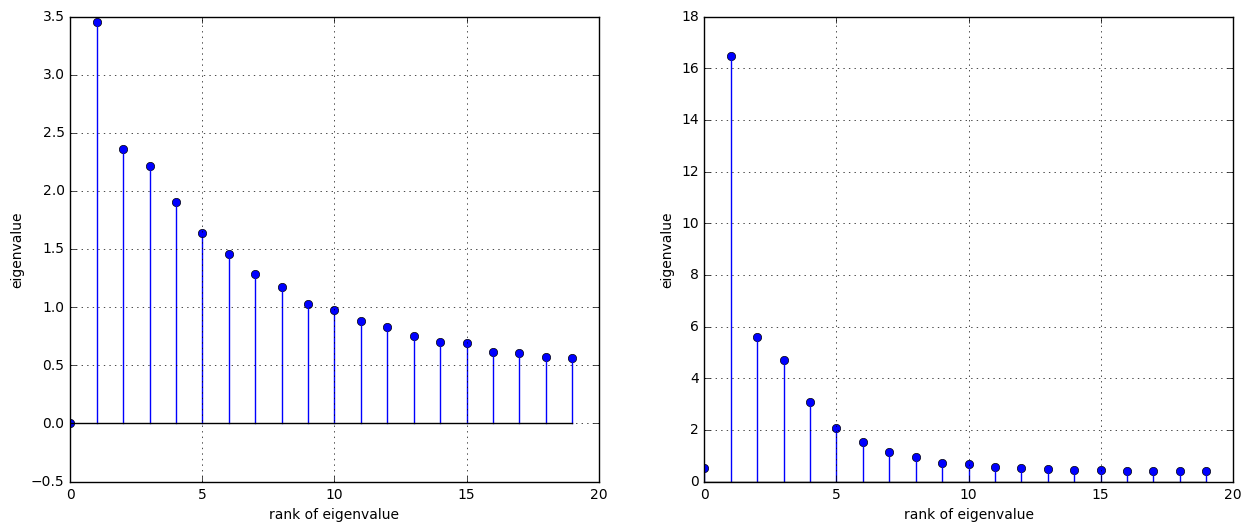

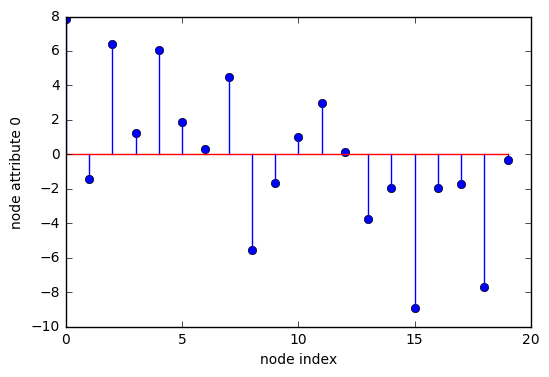

In [5]:
Tmax = 1
option_sig = {}
option_sig['mat'] = 'laplacian_matrix' #'adjacency_matrix'
choice2 = 'polynomial'

if choice2 == 'l1_threshold':
    option_sig['method'] = choice2
    option_sig['threshold'] = 0.5
elif choice2 == 'polynomial':
    option_sig['method'] = choice2
    degree_val = np.array(list(G0.degree().values()))
    bias = 1/np.sqrt(np.mean(degree_val))
    option_sig['coeffs'] = [bias, -1/2, 1/3, 1/3]
elif choice2 == 'rescale':
    option_sig['method'] = choice2
    option_sig['weights'] = np.random.rand((len(G0),))
elif choice2 == 'sigmoid_theshold':
    option_sig['method'] = choice2
    option_sig['rate'] = 1
    option_sig['shift'] = 0.5
    option_sig['bias'] = 0
    
     
    
G0_node, X0, _= LSN.smooth_gsignal_filter(G0, option_sig, sigma=10, seed=10, add_noise=False, show_plot=True, save_fig=savefigure)
#G0_node, X0, hist_tv = LSN.smooth_gsignal_generate(G0, T=Tmax, sigma=10, alpha=0.2, seed=10, add_noise=False, overwrite=True)
fig1 = plt.figure(1)
if 'bipartite' in choice:
    node_sets = bipartite.sets(G0)
    (markerline, stemlines, baseline) = plt.stem(np.arange(len(node_sets[0])),X0[0:len(node_sets[0]),0], 'r')
    plt.setp(markerline, 'markerfacecolor', 'r')
    (markerline, stemlines, baseline) = plt.stem(len(node_sets[0])+np.arange(len(node_sets[1])),X0[len(node_sets[0]):len(G0),0], 'b')
    plt.setp(markerline, 'markerfacecolor', 'b')
else:    
    (markerline, stemlines, baseline) = plt.stem(np.arange(X0.shape[0]),X0[:,0])
plt.xlabel('node index')
plt.ylabel('node attribute 0')
plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_node_fea0.eps"
if savefigure : fig1.savefig(filename)

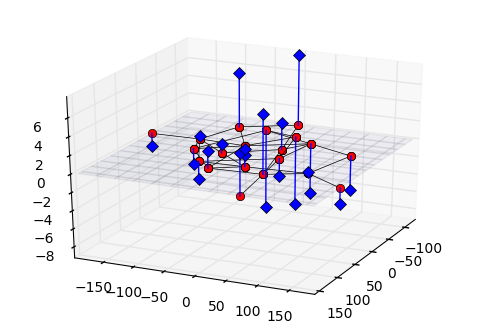

In [6]:
if choice == 'newman' or choice == 'tree':
    pos=nx.circular_layout(G0, dim=2, scale=1.0, center=None)
elif choice == 'grid':
    pos=dict(zip(G0.nodes(), [np.asarray(u) for u in G0.nodes()]))
elif 'bipartite' in choice:
    pos=nx.nx_pydot.graphviz_layout(G0, prog='dot')
else:
    pos=nx.nx_pydot.graphviz_layout(G0)
    
X0_2, nodeIdx = LSN.get_node_attributes(G0_node)
pos_coordinate = np.array([[pos[it['node']][0], pos[it['node']][1]] for it in nodeIdx])

edge_list = LSN.get_edgelist(G0_node)

view_angle = [25, 25] #[25, 180]
LSN.plot_node_3d(pos_coordinate, edge_list, X0_2, view_angle=view_angle, nodeIdx=nodeIdx, save_fig=savefigure)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [12, 13, 14, 15, 16, 17, 18, 19]]

In [8]:
observed_idx = [item['loc'] for item in nodeIdx if item['node'] in node_sets[0]]
hidden_idx = [item['loc'] for item in nodeIdx if item['node'] in node_sets[1]]
X_o = X0[observed_idx,:]
X_h = X0[hidden_idx,:]
mask = np.ones((len(G0), len(G0)))
mask[np.ix_(observed_idx, observed_idx)] = np.ones((len(node_sets[0]), len(node_sets[0])))

##  Use EM-glasso to learn the latent variable sparse inverse covariance estimation

For $t = 1, 2, \ldots, $
 1. M-Step:  find sparse inverse covariance for joint (observerd, latent)
 
    \begin{eqnarray}
     \widehat{\mathbf{\Theta}}_{(o,h),t}^{*} &= \arg\min_{\mathbf{\Theta}} -\frac{m}{2}\log\det\left(\mathbf{\Theta}\right)+ \frac{m}{2}\text{tr}\left(\widehat{\mathbf{\Sigma} }_{(o,h), (t-1)}\left( \mathbf{\Theta}\right)\right) + \alpha_{m}  \|\mathbf{P} \odot \mathbf{\Theta}\|_{1} \\
     &\phantom{=}\text{s.t. }\quad \mathbf{\Theta}\succeq \mathbf{0}  \nonumber
    \end{eqnarray}
    where $\odot$ is piecewise product. and 
    \begin{align}
    \mathbf{P} &= \left[
    \begin{array}{cc}
    \mathbf{J}_{o} & \mathbf{0}_{o,h}\\
    \mathbf{0}_{h,o} & \mathbf{0}_{h}
    \end{array}
    \right]
    \end{align} for $\mathbf{J} \in \mathbb{R}^{o\times o}$ all 1s matrix.
    
 2. E-Step:  find the expected empirical covariance over joint (observed, latent) variables given observed variables
     
     \begin{align}
       \widehat{\mathbf{\Sigma}}_{(o,h), t} \big| \left(\mathbf{\Sigma}_{o}, \widehat{\mathbf{\Theta}}_{(o,h),t}^{*}\right) &= 
       \left[
        \begin{array}{cc}
        \mathbf{\Sigma}_{o} & -\mathbf{\Sigma}_{o}\widehat{\mathbf{\Theta}}_{o,h,t}\\
        -\widehat{\mathbf{\Theta}}_{h,o,t}\mathbf{\Sigma}_{o} & \left(\mathbf{\Sigma}_{h}\right)^{-1} + 
        \widehat{\mathbf{\Theta}}_{h,o,t}\mathbf{\Sigma}_{o}\widehat{\mathbf{\Theta}}_{o,h,t}
        \end{array}
       \right]
     \end{align}
     
     In implementation, we let $\mathbf{\Sigma}_{h} = \mathbf{I}.$

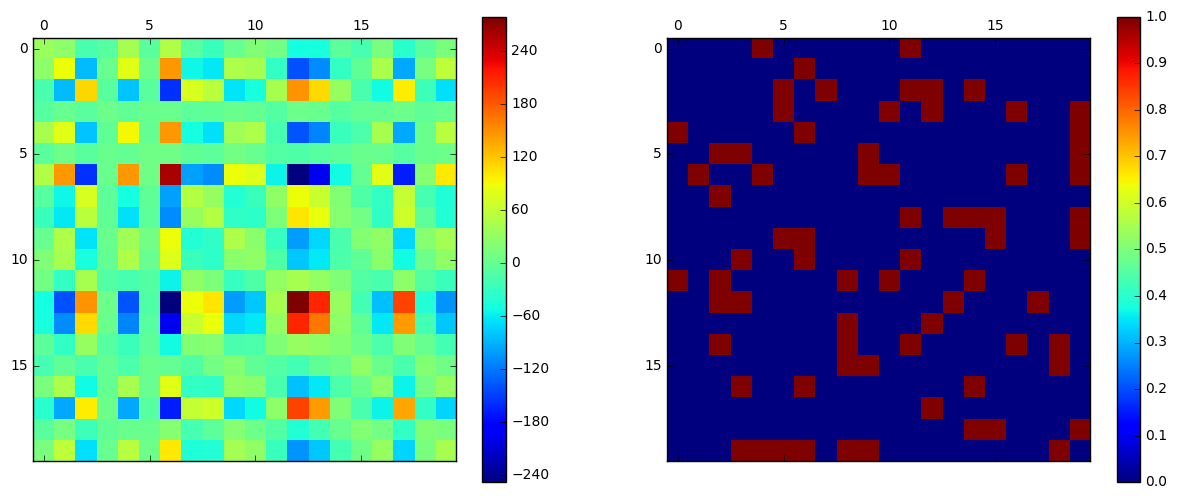

In [9]:
n, m = X_o.shape
emp_cov = np.cov(X_o)

lambda_s = 1
fig2= plt.figure(2, figsize=(15,6))
ax = fig2.add_subplot(121)
cax = ax.matshow(np.cov(X0))
fig2.colorbar(cax)

ax = fig2.add_subplot(122)
adjMatSparse =  nx.adjacency_matrix(G0)
adjMat = adjMatSparse.todense()
cax = ax.matshow(adjMat)
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])
plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_cov_adjmat.eps"
if savefigure : fig2.savefig(filename)

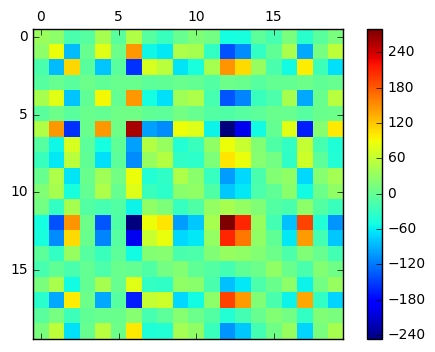

In [10]:
fig2= plt.figure(2)
ax = fig2.add_subplot(111)
cax = ax.matshow(np.cov(X0))
fig2.colorbar(cax)


plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_cov_all.eps"
if savefigure : fig2.savefig(filename)

In [11]:
from latent_graphical_lasso import latent_variable_glasso_data

/home/tianpei/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [36]:
alpha = 0.034
covariance_em_o, precision_em_o, _, prec_all_list_em = \
                    latent_variable_glasso_data(X_o, alpha=alpha, max_iter_out = 8, max_iter_in=100, 
                                               verbose=True, return_hists=True)

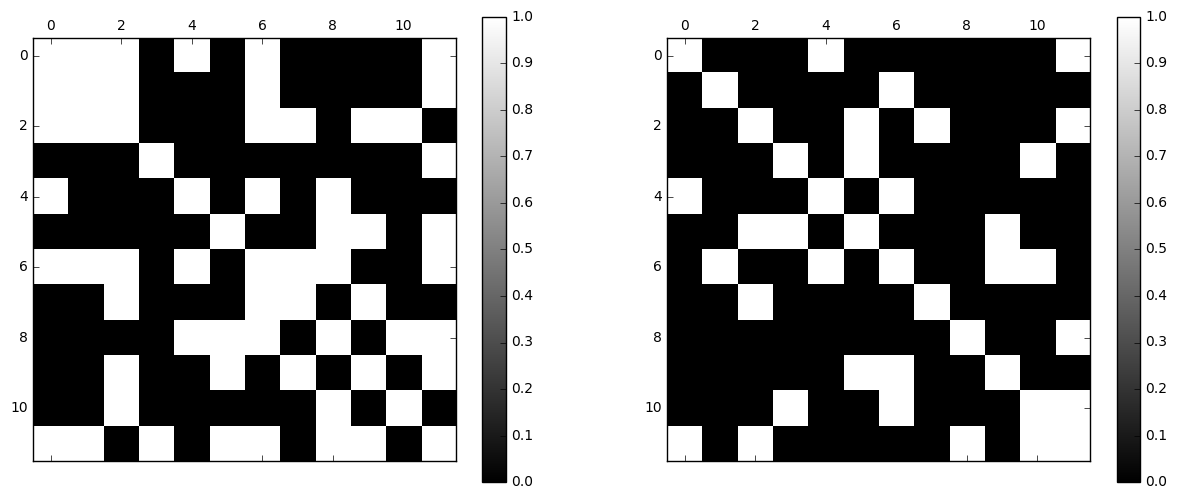

In [37]:
# plot the precision matrix and the support of Laplacian matrix
fig2= plt.figure(2, figsize=(15,6))
ax = fig2.add_subplot(121)
cax = ax.matshow(np.sign(abs(precision_em_o)),   cmap=plt.cm.gray)
fig2.colorbar(cax)

ax = fig2.add_subplot(122)



cax = ax.matshow(np.sign(abs(Laplacian[np.ix_(node_lists[0], node_lists[0])])),  cmap=plt.cm.gray)
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_laplacian_em.eps"
if savefigure : fig2.savefig(filename)

In [ ]:
# plot the precision matrix and the support of Laplacian matrix
fig2= plt.figure(2, figsize=(15,6))
ax = fig2.add_subplot(121)
cax = ax.matshow(precision_em_o, vmin=-0.5, vmax=2)
fig2.colorbar(cax)

ax = fig2.add_subplot(122)



cax = ax.matshow(Laplacian[np.ix_(node_lists[0], node_lists[0])])
fig2.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_laplacian_em.eps"
if savefigure : fig2.savefig(filename)

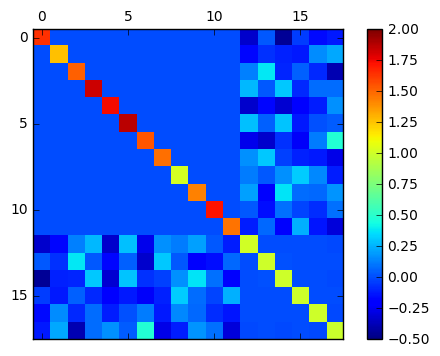

In [14]:
# the support of learned inverse covariance matrix and the support of adjacency matrix 
fig2= plt.figure(2)
ax = fig2.add_subplot(111)
cax = ax.matshow(prec_all_list_em[-1], vmin=-0.5, vmax=2)
fig2.colorbar(cax)

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_all_em_noise_hidden.eps"
if savefigure : fig2.savefig(filename)

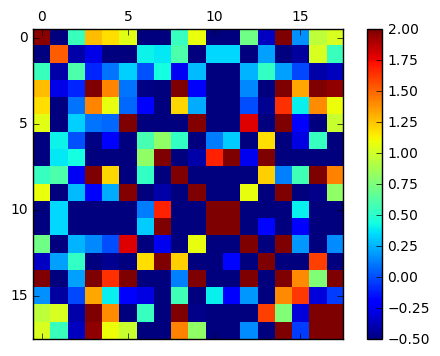

In [15]:
# the support of learned inverse covariance matrix and the support of adjacency matrix 
fig2= plt.figure(2)
ax = fig2.add_subplot(111)
cax = ax.matshow(prec_all_list_em[0], vmin=-0.5, vmax=2)
fig2.colorbar(cax)

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_all_em_0.eps"
if savefigure : fig2.savefig(filename)

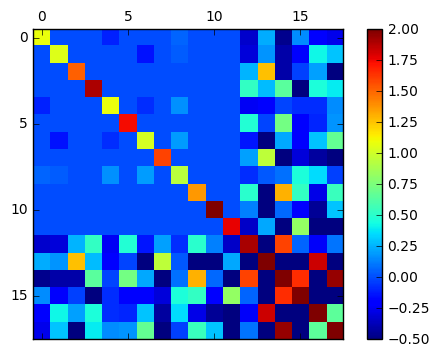

In [16]:
# the support of learned inverse covariance matrix and the support of adjacency matrix 
fig2= plt.figure(2)
ax = fig2.add_subplot(111)
cax = ax.matshow(prec_all_list_em[1],  vmin=-0.5, vmax=2)
fig2.colorbar(cax)

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_all_em_1.eps"
if savefigure : fig2.savefig(filename)

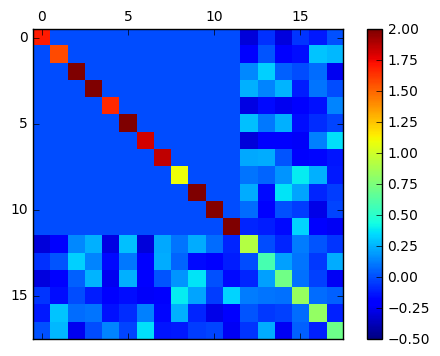

In [17]:
# the support of learned inverse covariance matrix and the support of adjacency matrix 
fig2= plt.figure(2)
ax = fig2.add_subplot(111)
cax = ax.matshow(prec_all_list_em[2], vmin=-0.5, vmax=2)
fig2.colorbar(cax)

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_all_em_2.eps"
if savefigure : fig2.savefig(filename)

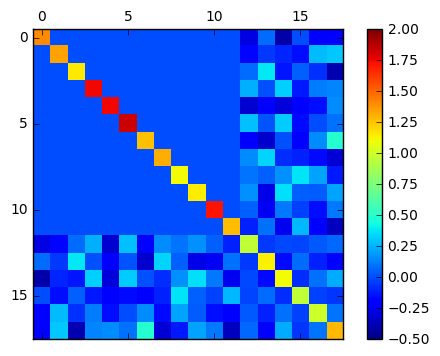

In [18]:
fig2= plt.figure(2)
ax = fig2.add_subplot(111)
cax = ax.matshow(prec_all_list_em[3], vmin=-0.5, vmax=2)
fig2.colorbar(cax)

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_all_em_3.eps"
if savefigure : fig2.savefig(filename)

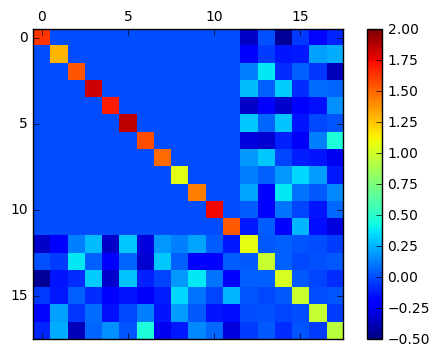

In [19]:
fig2= plt.figure(2)
ax = fig2.add_subplot(111)
cax = ax.matshow(prec_all_list_em[4], vmin=-0.5, vmax=2)
fig2.colorbar(cax)

plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_all_em_4.eps"
if savefigure : fig2.savefig(filename)

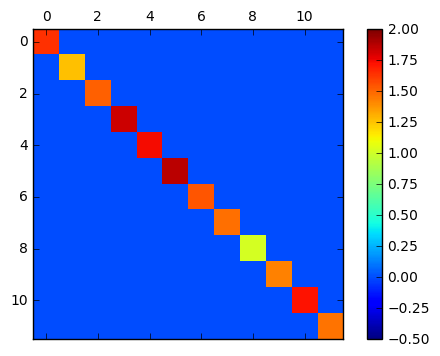

In [20]:
# plot the precision matrix and the support of Laplacian matrix
fig2= plt.figure(2)
ax = fig2.add_subplot(111)
cax = ax.matshow(precision_em_o, vmin=-0.5, vmax=2)
fig2.colorbar(cax)


plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_precision_o_em.eps"
if savefigure : fig2.savefig(filename)

See that the estimated precision matrix by latent-variable-gmm is not sparse. 